In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
from datetime import datetime, timedelta
import cmocean
from matplotlib.dates import DateFormatter
import glob
import pandas as pd
import xarray as xr
from sklearn.neighbors import LocalOutlierFactor

## load in fancy model
from sklearn import preprocessing 
import statsmodels.api as sm
import warnings; warnings.simplefilter('ignore')

In [3]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [4]:
simba_filepath = '/psd3data/arctic/raven/simba/level1/'
lev1_files = glob.glob(simba_filepath+'*.nc')
lev1_files.sort()

## on our server the simba files include some days from march during testing; this gets rid of those files
lev1_files = lev1_files[5:]

In [5]:
## these are the only variables I've used so far from the SIMBA
varnames = ['temperature','height','time']

season_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)

    fstart_time = datetime.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in season_data:
            season_data[var] = fdic[var]
        else:
            season_data[var] = np.ma.concatenate( (season_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'height' not in season_data:
        season_data['height'] = fdic['height']
        
    ## shape of temperature is (time, height)
    # print(season_data['dates'].shape, season_data['height'].shape, season_data['temperature'].shape)

In [6]:
simba_temps = season_data['temperature']
simba_heights = season_data['height']
simba_dates = season_data['dates']

In [7]:
vert_grad = np.gradient(simba_temps, axis=1)
second_vert_grad = np.gradient(vert_grad, axis=1)

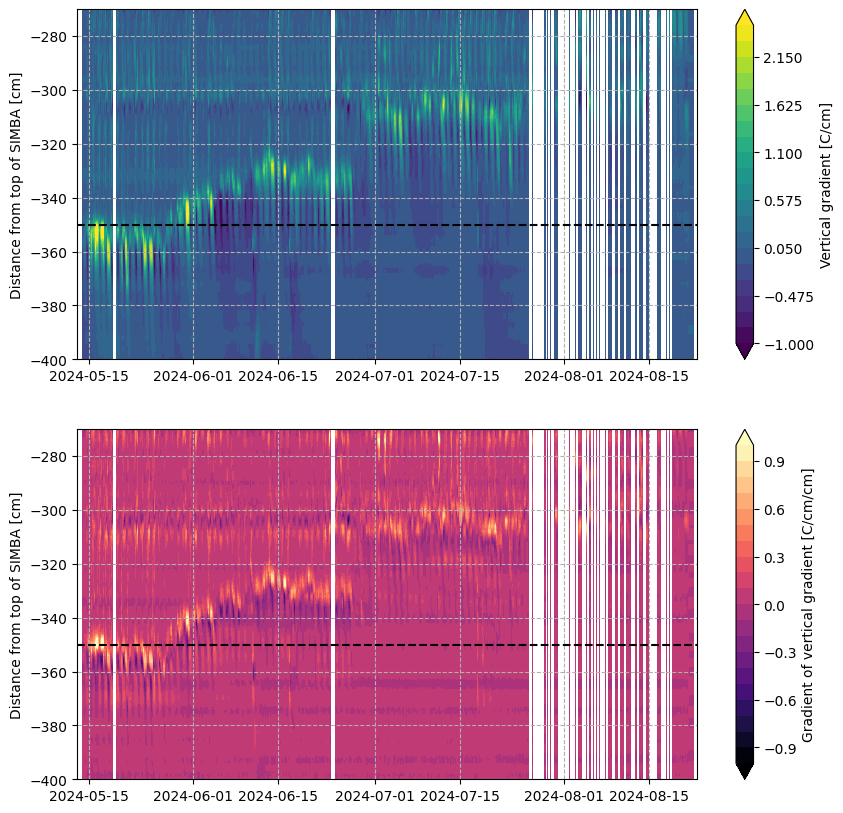

In [8]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)


cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                cmap=plt.cm.viridis, levels=np.linspace(-1,2.5,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

second_vert_profiles = np.ma.masked_outside(second_vert_grad,-200,200)
cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                cmap='magma', levels=np.arange(-1,1.1,.1), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])


axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    # ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7,30))
    

plt.show()

In [9]:
def get_simba_level1(start_time=datetime(2024,5,10), end_time=datetime(2024,8,23), l1_dir='/psd3data/arctic/raven/simba/level1/'):
    dates = pd.date_range(start_time, end_time)
    lev1_files = [f'{l1_dir}/firnprofile*{d.strftime("%Y%m%d")}*' for d in dates]
    filenames = []

    for f in lev1_files: 
        try: filenames.append(glob.glob(f)[0])
        except: 
            print(f"... couldnt open {f}")

    #print(filenames)
    try: 
        ds = xr.open_mfdataset(filenames)
    except Exception as e:
        print(f"... couldn't open, returning file list... \n {e}")
        return filenames
    return ds

In [10]:

simba_dates = season_data['dates']
second_vert_grad = np.gradient(vert_grad, axis=1)

## Load data into pandas dataframe
sds = get_simba_level1()

## add second vertical temperature gradient to data frame
## why can't this be done in pandas?
sds['dT2_dH2'] = (["time", "height"], second_vert_grad)


... couldnt open /psd3data/arctic/raven/simba/level1//firnprofile*20240510*
... couldnt open /psd3data/arctic/raven/simba/level1//firnprofile*20240511*
... couldnt open /psd3data/arctic/raven/simba/level1//firnprofile*20240512*
... couldnt open /psd3data/arctic/raven/simba/level1//firnprofile*20240727*
... couldnt open /psd3data/arctic/raven/simba/level1//firnprofile*20240731*
... couldnt open /psd3data/arctic/raven/simba/level1//firnprofile*20240815*
... couldnt open /psd3data/arctic/raven/simba/level1//firnprofile*20240823*


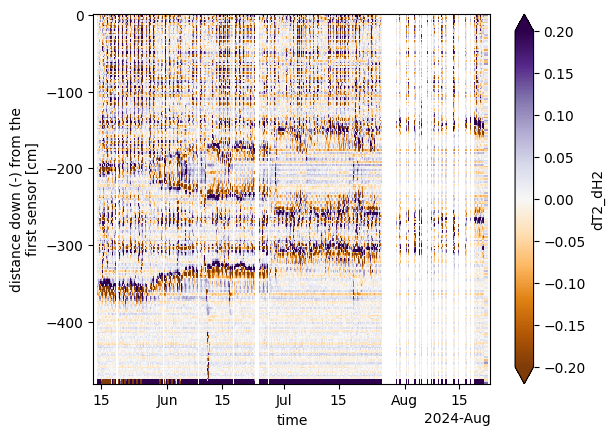

In [11]:
sds['dT2_dH2'].plot(x='time', vmin=-.2, vmax=.2, cmap='PuOr')


In [12]:
## subset data by time (don't include after major outage)
## subsetting by height matters! remove noisier levels above surface and include more below
ds_slice = sds.loc[dict(time=slice(datetime(2024,5,15),datetime(2024,7,25)), height=slice(-275,-450))]

df = ds_slice['dT2_dH2'].to_pandas().transpose()

In [13]:
## removing columns that have nans in them (missing data in above plot)
print(df.index)
print(df.columns)
print(df)

for c in df.columns:
    if df[c].isna().sum()>0:
        df = df.drop([c], axis=1)

print(df)

Index([-276, -278, -280, -282, -284, -286, -288, -290, -292, -294, -296, -298,
       -300, -302, -304, -306, -308, -310, -312, -314, -316, -318, -320, -322,
       -324, -326, -328, -330, -332, -334, -336, -338, -340, -342, -344, -346,
       -348, -350, -352, -354, -356, -358, -360, -362, -364, -366, -368, -370,
       -372, -374, -376, -378, -380, -382, -384, -386, -388, -390, -392, -394,
       -396, -398, -400, -402, -404, -406, -408, -410, -412, -414, -416, -418,
       -420, -422, -424, -426, -428, -430, -432, -434, -436, -438, -440, -442,
       -444, -446, -448, -450],
      dtype='int64', name='height')
DatetimeIndex(['2024-05-15 00:00:00', '2024-05-15 00:15:00',
               '2024-05-15 00:30:00', '2024-05-15 00:45:00',
               '2024-05-15 01:00:00', '2024-05-15 01:15:00',
               '2024-05-15 01:30:00', '2024-05-15 01:45:00',
               '2024-05-15 02:00:00', '2024-05-15 02:15:00',
               ...
               '2024-07-24 21:45:00', '2024-07-24 22:00

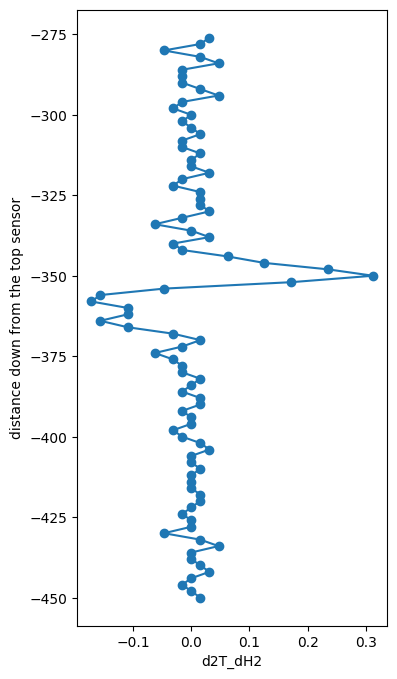

In [14]:
## Example of profile that looks like it should have an anomaly
fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)

for c in df.columns:
    axs.plot(df[c],df.index, marker='o')
    axs.set_ylabel('distance down from the top sensor')
    axs.set_xlabel('d2T_dH2')
    break

In [70]:
# runnning our fancy model: removing profiles that have significant white noise based on pvalues
pvals = []

mms = preprocessing.MinMaxScaler((-1,1))
# m = mms.fit_transform(df.transpose().values)
# df_scaled[:] = mms.fit_transform(df.transpose().values).transpose()
df_filtered = df.copy()
lb_test_results = []

p_threshold = 0.00001
print("... beginning ARIMA tests for noise quantification...")
args_list = []

def run_noise_test(dff, icol):
    
    p_threshold=0.00001
    if icol % 500 == 0: print(f"... still running {icol} !!")
    
    # pass me a single column of data
    try: 
        arima_res = sm.tsa.ARIMA(dff).fit()
        jb_res = sm.stats.acorr_ljungbox(arima_res.resid, return_df=True)
        pval_mean = jb_res['lb_pvalue'].mean()
        if  pval_mean > p_threshold: # original threshold: 0.00001
            return True, dff.name, pval_mean
        else:
            return False, dff.name, pval_mean
    except Exception as e:
        print(f"... testing {dff.name} failed")
        return True, dff.name, np.nan

args_list = [(df_filtered[c], icol) for icol,c in enumerate(df.columns)]
    
#for icol,c in enumerate(df.columns):
    # args_list.append((df_filtered[c], ))
    
    # arima_res = sm.tsa.ARIMA(df_filtered[c]).fit()
    # jb_res = sm.stats.acorr_ljungbox(arima_res.resid, return_df=True)
    # lb_test_results.append(jb_res)
    # pvals.append(jb_res['lb_pvalue'].mean())
    # if jb_res['lb_pvalue'].mean() > p_threshold: # original threshold: 0.00001
    #     df_filtered[c] = np.nan

import multiprocessing
with multiprocessing.Pool(processes=24) as pool:
    results = pool.starmap(run_noise_test, args_list)

pvals = []
for test_result, column_name, pval_mean in results:
    pvals.append(pval_mean)
    if test_result == True:
        df_filtered[column_name] = np.nan

... beginning ARIMA tests for noise quantification...
... still running 0 !!
... still running 500 !!
... still running 1000 !!
... still running 1500 !!
... still running 2000 !!
... still running 2500 !!
... still running 3500 !!
... still running 3000 !!
... still running 4000 !!
... still running 4500 !!
... still running 5000 !!
... still running 5500 !!
... still running 6000 !!
... still running 6500 !!


In [67]:
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')

In [71]:
print(np.percentile(pvals,50))

1.8648048469365032e-08


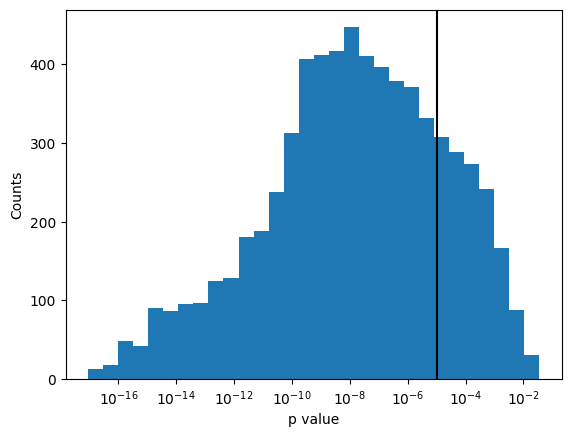

In [72]:
plot_loghist(pvals, 30)
plt.xlabel('p value')
plt.ylabel('Counts')
plt.axvline(x=p_threshold, c='k')
plt.show()

In [73]:
num_nan = df_filtered.isna().sum().sum()
num_tot = len(df_filtered)*len(df_filtered.iloc[0])
print(f" !!! threw out {np.round((num_nan/num_tot)*100,2)}% data points!!!")

 !!! threw out 20.3% data points!!!


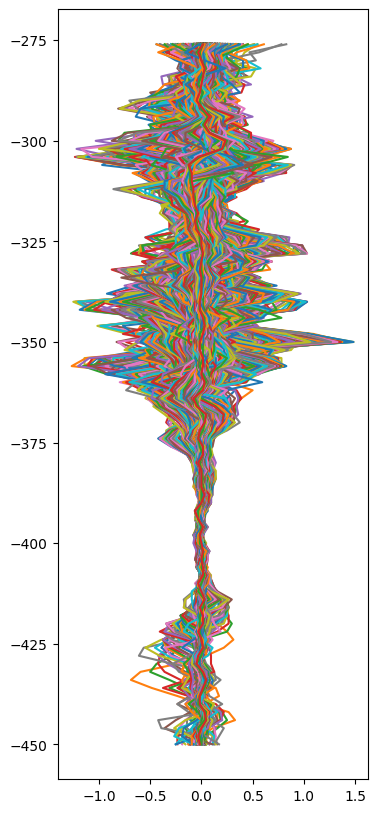

In [22]:
fig, axs = plt.subplots(1,1, figsize=(4,10), sharey=True)

for c in df.columns:
    axs.plot(df_filtered[c],df_filtered.index)

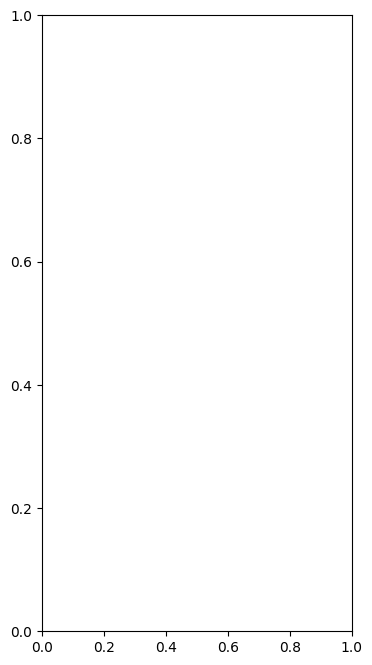

In [105]:
## THIS DOESN'T RUN IN ORDER!
fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
times = pd.DataFrame(anoms.columns)

prev_day = anoms.columns[0].floor("D")
for i, c in enumerate(anoms.columns):
    curr_day = c.floor("D") 
    if curr_day>prev_day: 
        prev_day = curr_day
        fig.savefig(f"plots/surface_anom_tests_filtered_{c.strftime('%Y%m%d')}.png")
        plt.close(fig)
        fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
    else:
        #axs.plot(anoms[c],anoms.index, color='sienna', alpha=0.4)
        axs.plot(df_filtered[c],dfs.index, color='cadetblue', alpha=0.4)
    

In [74]:
# drop nan columns
dff = df_filtered.copy()
for c in dff.columns:
    if dff[c].isna().sum()>0:
        dff = dff.drop([c], axis=1)

HERE: trying to understand if .transpose() if doing what we want

In [75]:
t_dff = dff.copy()
print(t_dff.index)
t_dff = t_dff.transpose()
print(t_dff.index)

Index([-276, -278, -280, -282, -284, -286, -288, -290, -292, -294, -296, -298,
       -300, -302, -304, -306, -308, -310, -312, -314, -316, -318, -320, -322,
       -324, -326, -328, -330, -332, -334, -336, -338, -340, -342, -344, -346,
       -348, -350, -352, -354, -356, -358, -360, -362, -364, -366, -368, -370,
       -372, -374, -376, -378, -380, -382, -384, -386, -388, -390, -392, -394,
       -396, -398, -400, -402, -404, -406, -408, -410, -412, -414, -416, -418,
       -420, -422, -424, -426, -428, -430, -432, -434, -436, -438, -440, -442,
       -444, -446, -448, -450],
      dtype='int64', name='height')
DatetimeIndex(['2024-05-15 00:00:00', '2024-05-15 00:15:00',
               '2024-05-15 00:30:00', '2024-05-15 00:45:00',
               '2024-05-15 01:00:00', '2024-05-15 01:15:00',
               '2024-05-15 01:30:00', '2024-05-15 01:45:00',
               '2024-05-15 02:00:00', '2024-05-15 02:15:00',
               ...
               '2024-07-24 20:45:00', '2024-07-24 21:00

In [191]:
# do the normalization/scaling in the horizontal for bumping signal to noise ratio
# rsdf = dff.copy()
# mms = preprocessing.RobustScaler(quantile_range=(0.4,0.6),with_centering=True)
# m = mms.fit_transform(rsdf.transpose()) # original with transpose()
# dfs = pd.DataFrame(m.transpose(), columns=dff.columns,index=dff.index) # original with transpose


In [300]:
# this is scaling in the vertical but seems worse than horizontal
rsdf = dff.copy()
mms = preprocessing.RobustScaler(quantile_range=(0.1,0.9),with_centering=True)
m = mms.fit_transform(rsdf) # original with transpose()
dfs = pd.DataFrame(m, columns=rsdf.columns,index=rsdf.index)

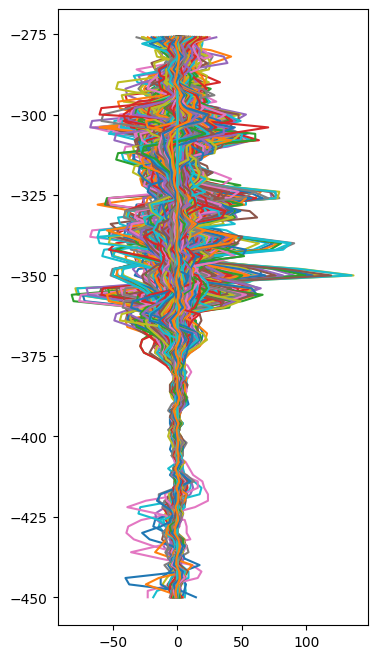

In [301]:
fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)

for c in dfs.columns:
    axs.plot(dfs[c],dfs.index)



Idea from michael: daily average sample???

In [302]:
model = LocalOutlierFactor(n_neighbors=20, contamination=0.3)
model.fit(dfs)
y_pred = model.fit_predict(dfs)
anoms = dfs[y_pred==-1]

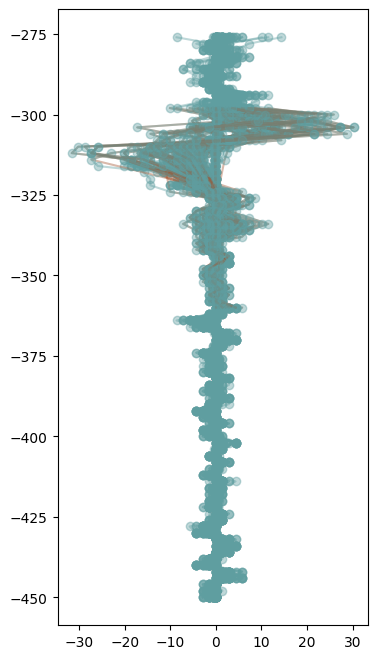

In [303]:
fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
times = pd.DataFrame(anoms.columns)

prev_day = anoms.columns[0].floor("D")
for i, c in enumerate(anoms.columns):
    curr_day = c.floor("D") 
    if curr_day>prev_day: 
        prev_day = curr_day
        fig.savefig(f"plots/surface_anom_tests_scaled_{c.strftime('%Y%m%d')}.png")
        plt.close(fig)
        fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
    else:
        axs.plot(anoms[c],anoms.index, color='sienna', alpha=0.4)
        axs.plot(dfs[c],dfs.index, color='cadetblue', alpha=0.4, marker='o')
        #axs.plot.scatter(dfs[c],dfs.index, color='cadetblue', alpha=0.4)

    

In [304]:
# the algorithm drops anything it doesn't identify as anomalous in height, recreate with np.nan in those places
fixed_anoms = df.copy()
fixed_anoms[:] = np.nan
aa = anoms.copy()
for c in anoms.columns:
    fixed_anoms.loc[anoms[c].index, c] = anoms[c]


In [305]:
aa = pd.DataFrame(columns=fixed_anoms.columns, index=['max_val','max_index'])

for c in fixed_anoms:
    max_i = fixed_anoms[c].abs().idxmax()
    max_v   = fixed_anoms[c].abs().max()
    aa.loc['max_val',c] = max_v
    aa.loc['max_index',c] = max_i

In [306]:
aa

time,2024-05-15 00:00:00,2024-05-15 00:15:00,2024-05-15 00:30:00,2024-05-15 00:45:00,2024-05-15 01:00:00,2024-05-15 01:15:00,2024-05-15 01:30:00,2024-05-15 01:45:00,2024-05-15 02:00:00,2024-05-15 02:15:00,...,2024-07-24 21:30:00,2024-07-24 21:45:00,2024-07-24 22:00:00,2024-07-24 22:15:00,2024-07-24 22:30:00,2024-07-24 22:45:00,2024-07-24 23:00:00,2024-07-24 23:15:00,2024-07-24 23:30:00,2024-07-25 00:00:00
max_val,28.735632,35.91954,0.34375,28.735632,31.609195,14.367816,13.649425,30.172414,14.367816,24.425287,...,24.425287,21.551724,20.114943,9.33908,0.21875,22.988506,10.775862,NaN,NaN,NaN
max_index,-350,-350,-350,-350,-350,-350,-350,-350,-350,-350,...,-300,-302,-300,-300,-300,-300,-300,NaN,NaN,NaN


... successfully calculated surface height for timestep 2024-05-16 00:00:00
... successfully calculated surface height for timestep 2024-05-17 00:00:00
... successfully calculated surface height for timestep 2024-05-18 00:00:00
... successfully calculated surface height for timestep 2024-05-19 09:30:00
... successfully calculated surface height for timestep 2024-05-20 00:00:00
... successfully calculated surface height for timestep 2024-05-21 00:00:00
... successfully calculated surface height for timestep 2024-05-22 00:00:00
... successfully calculated surface height for timestep 2024-05-23 00:00:00
... successfully calculated surface height for timestep 2024-05-24 00:00:00
... successfully calculated surface height for timestep 2024-05-25 00:00:00
... successfully calculated surface height for timestep 2024-05-26 03:45:00
... successfully calculated surface height for timestep 2024-05-27 04:30:00
... successfully calculated surface height for timestep 2024-05-28 00:00:00
... successf

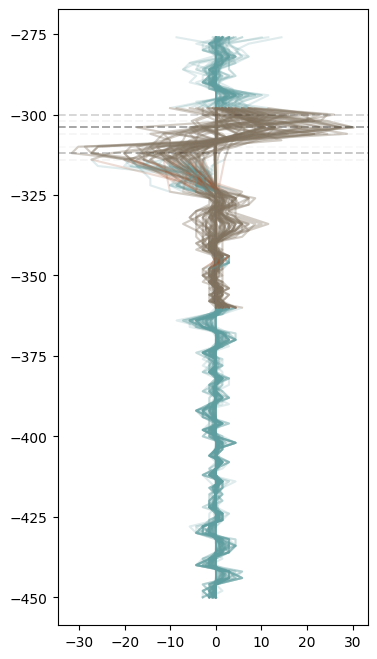

In [307]:
fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
times = pd.DataFrame(anoms.columns)

prev_day = anoms.columns[0].floor("D")
day_success = False

for i, c in enumerate(anoms.columns):

    curr_day = c.floor("D") 
    if curr_day>prev_day: 
        prev_day = curr_day
        fig.savefig(f"plots/surface_anom_tests_scaled_{c.strftime('%Y%m%d')}.png")
        plt.close(fig)
        fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
        if day_success: print(f"... successfully calculated surface height for timestep {c}")
        day_success = False
    else:
        axs.plot(dfs[c],dfs.index, color='cadetblue', alpha=0.2)
        axs.plot(anoms[c],anoms.index, color='sienna', alpha=0.2)
        try: 
            axs.axhline(y=aa.loc['max_index',c], color="black", linestyle="--",alpha=0.01)
            if day_success==False: 
                day_success = True
        except: 
            do_nothing = True
        #axs.plot.scatter(dfs[c],dfs.index, color='cadetblue', alpha=0.4)

In [308]:
def despike_rolling(df_column, window=10, threshold=3):
    rolling_median = df_column.rolling(window=window, center=True, min_periods=1).median()
    rolling_std = df_column.rolling(window=window, center=True, min_periods=1).std()
    df_clean = df_column[np.abs(df_column - rolling_median) <= (threshold * rolling_std)]
    return df_clean

In [309]:
print(aa)

time      2024-05-15 00:00:00 2024-05-15 00:15:00 2024-05-15 00:30:00  \
max_val             28.735632            35.91954             0.34375   
max_index                -350                -350                -350   

time      2024-05-15 00:45:00 2024-05-15 01:00:00 2024-05-15 01:15:00  \
max_val             28.735632           31.609195           14.367816   
max_index                -350                -350                -350   

time      2024-05-15 01:30:00 2024-05-15 01:45:00 2024-05-15 02:00:00  \
max_val             13.649425           30.172414           14.367816   
max_index                -350                -350                -350   

time      2024-05-15 02:15:00  ... 2024-07-24 21:30:00 2024-07-24 21:45:00  \
max_val             24.425287  ...           24.425287           21.551724   
max_index                -350  ...                -300                -302   

time      2024-07-24 22:00:00 2024-07-24 22:15:00 2024-07-24 22:30:00  \
max_val             20.114943   

In [310]:
## make time the index so that you can use groupby to get daily/hourly/whatever statistics
aa_formated = aa.copy().transpose()

In [311]:
print(aa_formated)

                       max_val max_index
time                                    
2024-05-15 00:00:00  28.735632      -350
2024-05-15 00:15:00   35.91954      -350
2024-05-15 00:30:00    0.34375      -350
2024-05-15 00:45:00  28.735632      -350
2024-05-15 01:00:00  31.609195      -350
...                        ...       ...
2024-07-24 22:45:00  22.988506      -300
2024-07-24 23:00:00  10.775862      -300
2024-07-24 23:15:00        NaN       NaN
2024-07-24 23:30:00        NaN       NaN
2024-07-25 00:00:00        NaN       NaN

[6627 rows x 2 columns]


In [312]:
aa_6h = aa_formated.groupby(pd.Grouper(freq='6H'))

## .quantiles not playing nice with .groupy()?
aa_min_6h = []

for group in aa_6h:
    g = group[1]['max_index']#.values
    # print(g.quantile(0.25), g.quantile(0.75))

    # print(g['max_index'].between(-350,-340))
    middle_g = g[g.between(g.quantile(0.25), g.quantile(0.75))]
    print(middle_g.min())
    # group_middle = g.between(g.transform('quantile', 0.25), g.transform('quantile', 0.75))
    aa_min_6h.append(middle_g.min())

-350
-350
-350
-350
-350
-350
-354
-350
-350
-352
-358
-356
-356
-356
-358
-358
nan
-358
-356
-356
-356
-358
-356
-354
-358
-358
-358
-304
-352
-354
-356
-354
-352
-352
-356
-356
-356
-356
-358
-354
-356
-356
-358
-358
-352
-356
-358
-360
-360
-358
-356
-356
-356
-350
-356
-358
-358
-348
-348
-344
-342
-340
-344
-340
-340
-344
-344
-348
-338
-338
-342
-342
-338
-338
-342
-342
-336
-340
-342
-342
-338
-340
-342
-340
-340
-336
-338
-338
-342
-338
-338
-336
-338
-302
-338
-338
-348
-340
-340
-340
nan
-340
-340
-334
-332
-304
-330
-360
-360
-334
-328
-328
-328
-328
-326
-326
-324
-324
-326
-324
-326
-326
-326
-326
-326
-328
-330
-332
-328
-328
-330
-360
-332
-330
-336
-330
-330
-330
-304
-326
-328
-328
nan
-304
-324
-326
-328
-330
-332
-336
-336
-330
-330
-332
-336
-332
-330
-332
-336
nan
nan
-300
-336
-336
-330
-302
-306
-306
-330
-304
-304
-330
-332
-334
nan
-304
nan
-302
-302
-332
-308
-304
-312
-312
-308
-306
-312
-312
-306
-300
-302
-310
-306
-302
-304
-310
-310
-306
-306
-306
-306
-3

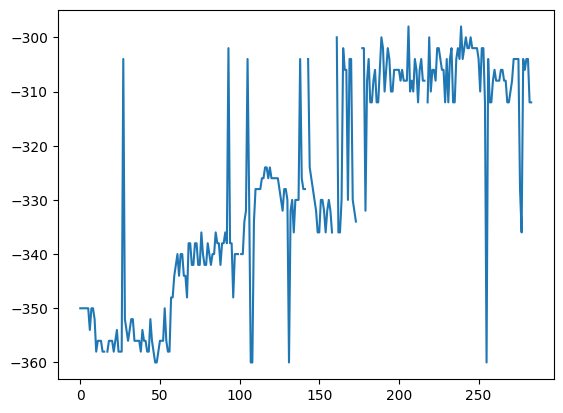

In [313]:
plt.plot(aa_min_6h)

In [314]:
aa_mode = aa_formated.groupby(pd.Grouper(freq='12H'))#.mode()
aa_min = aa_formated.groupby(pd.Grouper(freq='6H')).min()
aa_med = aa_formated.groupby(pd.Grouper(freq='6H')).median()


## groupby doesn't have option for mode???

days = []
modal_height = []

for item in aa_mode:
    days.append(item[1].index[0])
    try: 
        modal_height.append(item[1]['max_index'].mode().values.max())
    except:
        modal_height.append(np.nan)
    # print(item[1]['max_index'].mode().values)
# print(aa_mode)

In [315]:
despike_aa = despike_rolling(aa_min['max_index'], window=15, threshold=.75) 

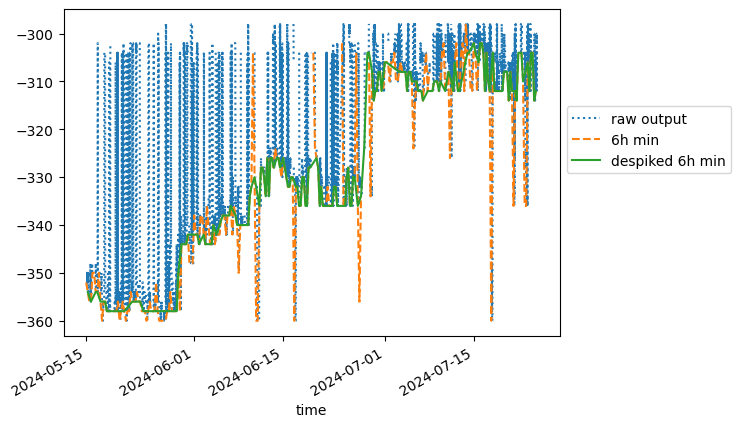

In [316]:
aa.loc['max_index',:].plot(ls=':', label='raw output')
aa_min['max_index'].plot(label='6h min', ls='--')
# aa_med['max_index'].plot(label='6h median')

# despike_aa_min.plot()
despike_aa.plot(label='despiked 6h min')
# plt.plot(days, modal_height, label='12h mode', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1,.6))
plt.show()
# plt.xlim(datetime(2024,6,1), datetime(2024,6,20))

In [317]:
## save to csv for comparison with other data/notebook
despike_aa.to_csv('Raven2024_SIMBA_sfc_id_v2_despiked_hourly_min_20250318.csv')


### Checking surface as compared to old surface ID

In [318]:
import math

def round_up_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return math.ceil(f / 2.) * 2

def round_down_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return 2 * (f // 2)

In [319]:
with np.load('/home/asledd/ICECAPS/Raven_SIMBA_sfc-id_max-T-grad.npz') as npz:
    simba_sfc_heights = np.ma.MaskedArray(**npz)

## I know this has 15 minute time steps, so average over several hours
kernel_avg_hrs= [1./(4*6+1)]*(4*6+1)

## broke convolve when updating cmocean; np.convolve has weird edge effects
# simba_sfc = convolve(simba_sfc_heights, kernel_avg_hrs, boundary='extend')
N = 4*6+1
simba_sfc = np.convolve(simba_sfc_heights, np.ones(N)/N, mode='same')

simba_sfc = np.ma.masked_invalid([round_up_to_even(height) for height in simba_sfc]) ## can also do round_down_to_even()
simba_sfc = np.ma.masked_where(season_data['dates']<datetime(2024,5,15,3), simba_sfc) # masked weird edges
simba_sfc = np.ma.masked_where(season_data['dates']>=datetime(2024,8,22,21), simba_sfc)

## this was a day with quick accumulation that gets unrealistically smoothed in the surface height
simba_sfc = np.ma.masked_where((season_data['dates']>=datetime(2024,6, 25))&(season_data['dates']<datetime(2024,6, 26)), simba_sfc)


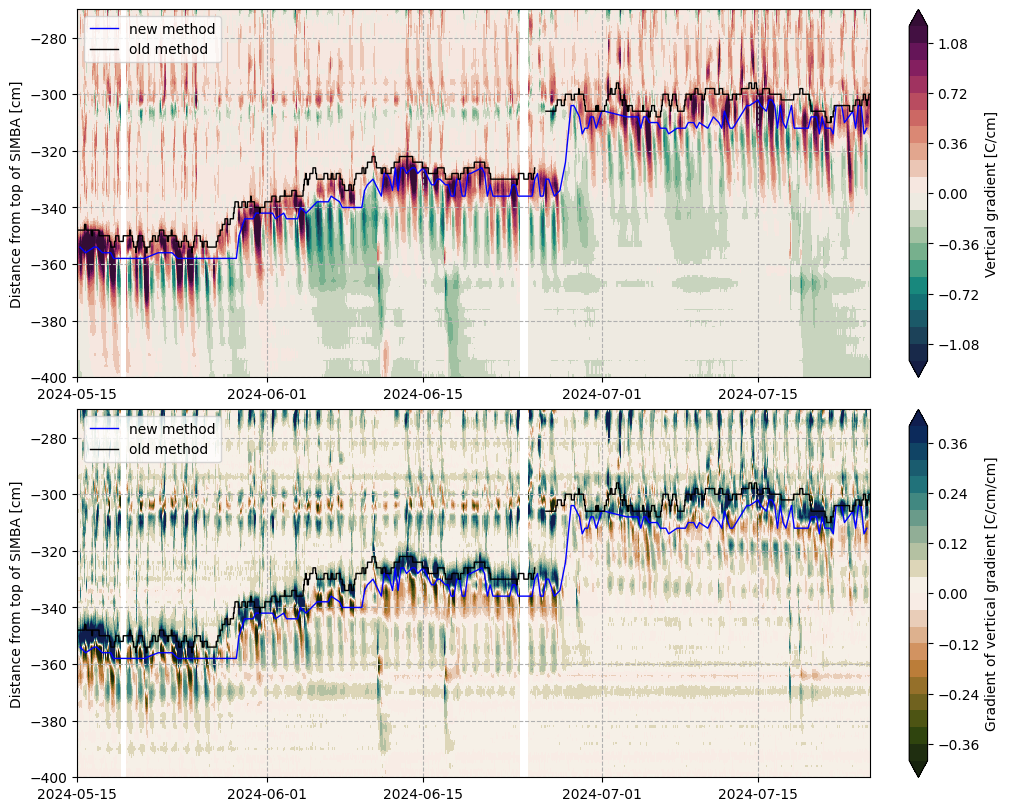

In [320]:

fig, axs = plt.subplots(2, figsize=(10,8), sharey=True, constrained_layout=True)


cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                cmap=cmocean.cm.curl, levels=np.linspace(-1.2,1.2,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

second_vert_profiles = np.ma.masked_outside(second_vert_grad,-200,200)
cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                cmap=cmocean.cm.tarn, levels=np.linspace(-.4,.4,21), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])


axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax, c in zip(axs.ravel(),['b','b']):
    ax.plot(despike_aa.index,despike_aa.values , c=c, label='new method', lw=1)
    ax.plot(season_data['dates'], simba_sfc, c='k', label='old method', lw=1)
    # ax.plot(season_data['dates'], simba_sfc-6., c='gray', ls='--')

    # ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    ax.set_xlim(datetime(2024,5,15), datetime(2024,7,25))
    
    ax.legend(loc='upper left')
plt.show()